# National Weather Model County Statistics


In [5]:
%load_ext watermark

import dask.array
import dask_jobqueue
import distributed
import flox
import flox.xarray
import pandas as pd
import numpy as np
import xarray as xr
from distributed import performance_report
from distributed.diagnostics.memory_sampler import MemorySampler
import utils
from functools import partial
import matplotlib.pyplot as plt

%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy        : 1.23.3
xarray       : 2022.9.0
pandas       : 1.5.0
distributed  : 2022.9.2
dask_jobqueue: 0.8.1
matplotlib   : 3.6.1
flox         : 0.6.2.dev6+gc370b5d
sys          : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]
dask         : 2022.9.2
json         : 2.0.9



In [2]:
zones_250m = r'/glade/scratch/ksampson/USDOT/Zonal_Statistics/Counties_on_250m_grid.tif'

counties = (
    xr.open_dataset(zones_250m, engine="rasterio")
    .squeeze()
    .band_data
    .reset_coords(drop=True)
)
counties = counties.where(counties > 0)

time = pd.date_range("2020-01-01", "2020-12-31 23:59", freq="D")
nwm = xr.Dataset(
        {
            "zwattablrt": (
                ("time", "y", "x"), 
                dask.array.random.random((len(time), 15360, 18432), chunks=(224, 350, 350)).astype(np.float32)
            ),
        },
        coords={"time": time, "x": counties.x, "y": counties.y}
    )
nwm

,Array,Chunk
Bytes,386.02 GiB,104.68 MiB
Shape,"(366, 15360, 18432)","(224, 350, 350)"
Count,2 Graph Layers,4664 Chunks
Type,float32,numpy.ndarray


In [3]:
repeats = 1

ms = MemorySampler()
for val in ["1.2", "inf"]:
    config = {"distributed.scheduler.worker-saturation": val}
    env={"DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION": val}

    with utils.get_cluster(n_workers=12, env=env, config=config) as (cluster, client):
        client.run_on_scheduler(partial(utils.check_config, config=config))

        for kwargs in [
            dict(method="map-reduce", reindex=False), 
            dict(method="map-reduce", reindex=True),
            dict(method="cohorts")
        ]:
            mean = flox.xarray.xarray_reduce(nwm, counties, func="mean", **kwargs)
            
            display(mean)

            with performance_report(f"nwm-groupby-map-reduce-{kwargs['method']}-{val}.html"):
                for repeat in range(repeats):
                    with ms.sample(f"{val}_{repeat}_{kwargs!r}"):
                        mean.compute(scheduler=client)
                    client.restart()

{'distributed.scheduler.worker-saturation': '1.2'}
https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status
asking for workers....
waiting for workers....
1.2


<xarray.Dataset>
Dimensions:     (time: 366, band_data: 3108)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * band_data   (band_data) float64 1.001e+03 1.003e+03 ... 5.604e+04 5.604e+04
Data variables:
    zwattablrt  (time, band_data) float32 dask.array<chunksize=(224, 3108), meta=np.ndarray>

<xarray.Dataset>
Dimensions:     (time: 366, band_data: 3108)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * band_data   (band_data) float64 1.001e+03 1.003e+03 ... 5.604e+04 5.604e+04
Data variables:
    zwattablrt  (time, band_data) float32 dask.array<chunksize=(224, 3108), meta=np.ndarray>

closing
{'distributed.scheduler.worker-saturation': 'inf'}
https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status
asking for workers....
waiting for workers....
inf


<xarray.Dataset>
Dimensions:     (time: 366, band_data: 3108)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * band_data   (band_data) float64 1.001e+03 1.003e+03 ... 5.604e+04 5.604e+04
Data variables:
    zwattablrt  (time, band_data) float32 dask.array<chunksize=(224, 3108), meta=np.ndarray>

<xarray.Dataset>
Dimensions:     (time: 366, band_data: 3108)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * band_data   (band_data) float64 1.001e+03 1.003e+03 ... 5.604e+04 5.604e+04
Data variables:
    zwattablrt  (time, band_data) float32 dask.array<chunksize=(224, 3108), meta=np.ndarray>

<xarray.Dataset>
Dimensions:     (time: 366, band_data: 3108)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * band_data   (band_data) float64 1.001e+03 1.003e+03 ... 5.604e+04 5.604e+04
Data variables:
    zwattablrt  (time, band_data) float32 dask.array<chunksize=(224, 1), meta=np.ndarray>

closing


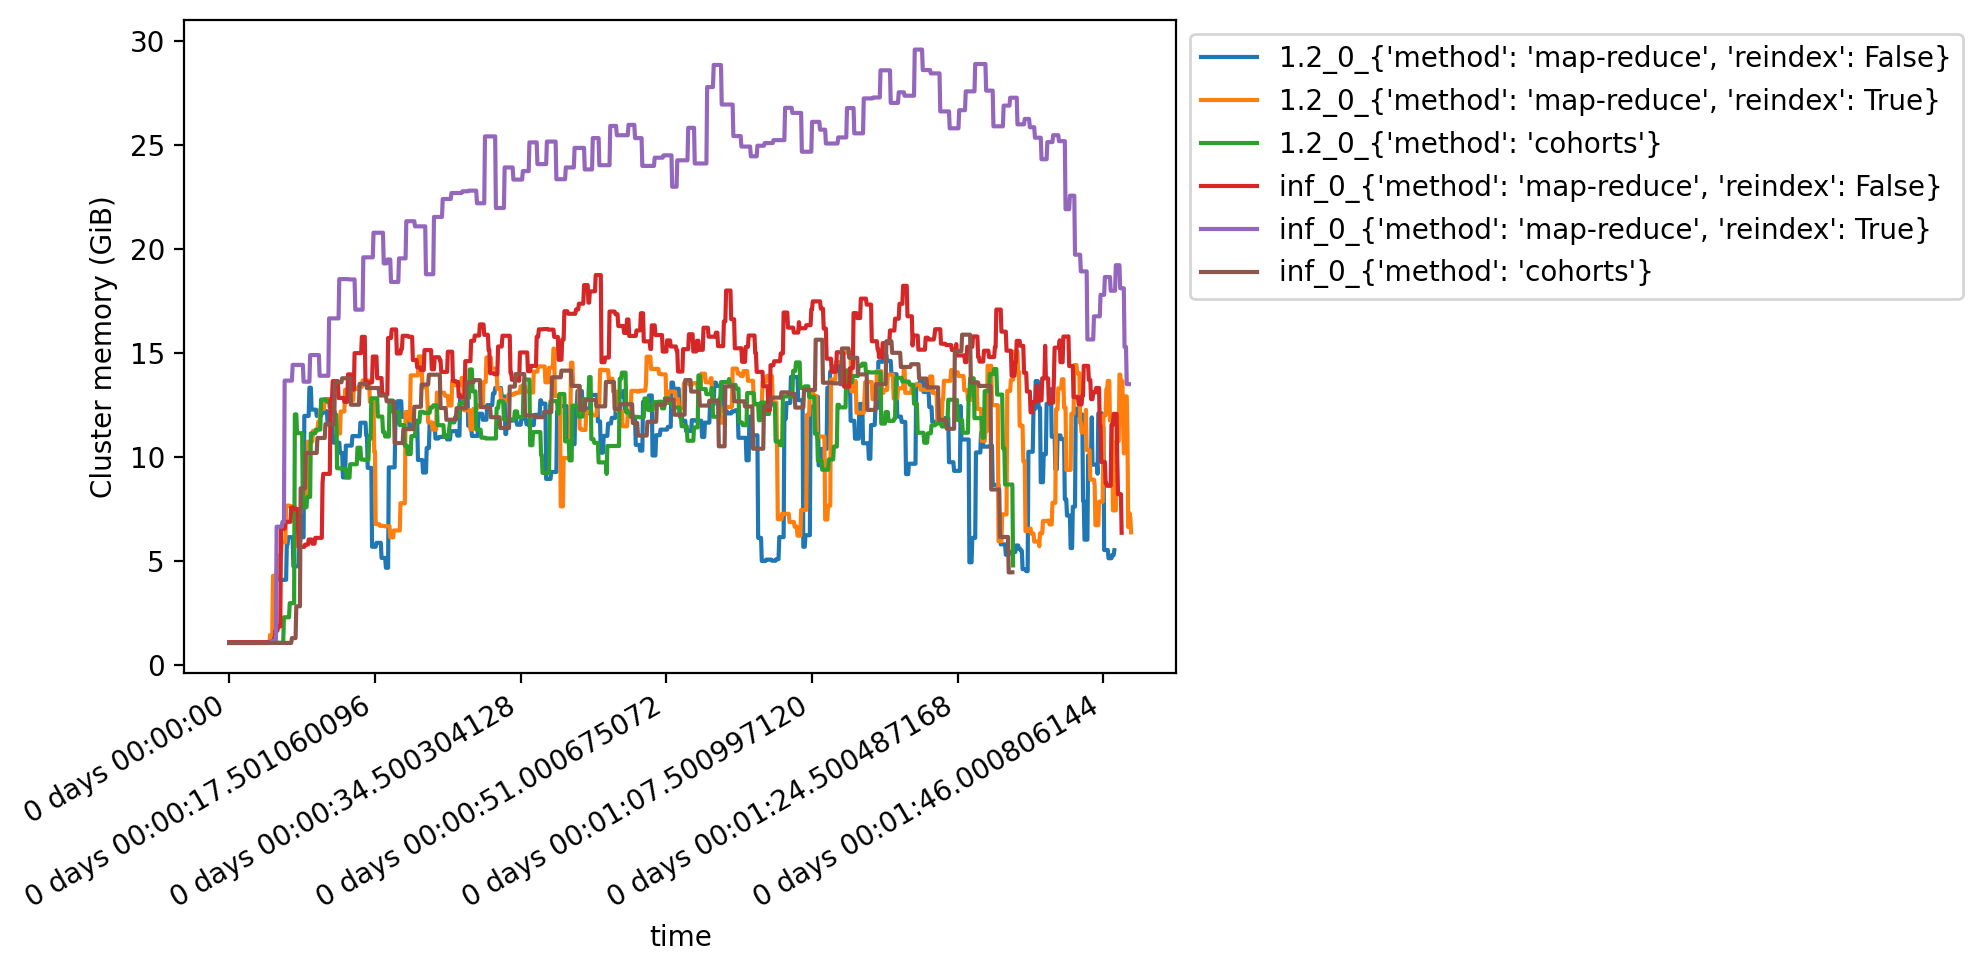

In [6]:
ms.plot(align=True, legend=False)
plt.legend(bbox_to_anchor=(1,1))

In [7]:
ms.to_pandas(align=True).to_csv("nwm-groupby-map-reduce-flox-latest.csv")